In [1]:
# automatically apply changes in netgen
%reload_ext autoreload
%autoreload 2

In [68]:
import os, sys
import pandas as pd
import numpy as np
import random
import math
from future.utils import listvalues
from copy import deepcopy

import cbgt.netgen as ng
import cbgt.analyzefx as afx
from cbgt import vis, sim

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.simplefilter('ignore', np.RankWarning)
warnings.filterwarnings("ignore", module="matplotlib")
warnings.filterwarnings("ignore")

%matplotlib inline
clrs = ['#347fff', '#febe08']
eclrs = ['#1657de', '#f5a005']

rc = {'font.family': u'sans-serif',
'font.sans-serif': [u'Helvetica',  u'Arial', u'sans-serif'],
'lines.solid_capstyle': u'butt'}
sns.set(style='ticks', font='Helvetica', rc=rc, font_scale=1.4)
# splot.style(theme='safari-day', grid=True, spines=True, fscale=1.4, figsize=(6., 3.5))
# bdf = pd.read_csv("/Users/kyle/demo_cbgt_bdf.csv")

In [69]:
import numpy as np 
import matplotlib.pyplot as plt 
import os 
import pandas as pd
from operator import sub, add
import glob
from random import shuffle
from itertools import product
from scipy import stats

## Global Params

In [84]:
parentDir = 'cbgtDemo'


savedir = os.path.join(os.path.expanduser('~'), parentDir)
if not os.path.isdir(savedir):
    os.mkdir(savedir)

BaseStim = 0
Stim = 2.54
Dynamic = 30.0
Choices = 2
rampingCTX = True
popscale = .3
Start=600

presetNo = ng.set_post_learning_weights(dMSN=[1.0, 1.0], iMSN=[1.0,1.0])
presetLow = ng.set_post_learning_weights(dMSN=[1.01, 0.99], iMSN=[1.0,1.0])
presetHi = ng.set_post_learning_weights(dMSN=[1.03, 0.98], iMSN=[1.0,1.0])
presets = [presetNo, presetLow, presetHi]

conds = ['no', 'low', 'high']
condABC = ['z', 'a', 'b']
cond12 = [0, 1, 2]

savedirs = [os.path.join(savedir, c) for c in conds]
saveNo, saveLow, saveHi = savedirs
saveTest=os.path.join(savedir, 'test')

presetDict = dict(zip(conds, presets))
condOrder = dict(zip(conds, condABC))
condLevel = dict(zip(conds+['test'], cond12+[0]))

# Efficacy sampling f(x) for individual networks

In [85]:
def get_sampling_params(scale=.05):

    
    CxSTR      =    0.2*.7*.9
    CxTh       =    0.03
    CxFSI      =    0.165*.8
    D1STR_GPi  =    1.10 #1.07
    D2STR_GPeP =    1.65
    STN_GPeP_A =    0.07
    STN_GPeP_N =    4.01
    STN_GPi    =    0.0324
    GPi_Th     =    0.067
    ThSTR      =    0.34*.75
    ThCx       =    0.02

    mu = dict(Cx={'STR':CxSTR, 'Th':CxTh, 'FSI':CxFSI}, 
                Th={'STR':ThSTR, 'Cx':ThCx},
                D1STR={'GPi': D1STR_GPi},
                D2STR={'GPeP': D2STR_GPeP},
                STN={'GPi': STN_GPi},
                GPi={'Th': GPi_Th})
    sd = {i:{j: mu[i][j]*scale for j in list(mu[i])} for i in list(mu)}
    return mu, sd


def sample_network_efficacies(muEff, sdEff, N):
    X = {}
    nuclei = list(muEff)
    for i in nuclei:
        targets = list(muEff[i])
        X[i] = {}
        for j in targets:
            X[i][j] = np.random.normal(muEff[i][j], sdEff[i][j], N)
    return X


def build_single_network(X, idx=0):
    
    Cx={'STR': X['Cx']['STR'][idx], 
        'Th': X['Cx']['Th'][idx], 
        'FSI': X['Cx']['FSI'][idx]}
    
    D1STR={'GPi': X['D1STR']['GPi'][idx]}
    D2STR={'GPeP': X['D2STR']['GPeP'][idx]}
    
    STN={'GPi': X['STN']['GPi'][idx]}
    
    GPi={'Th': X['GPi']['Th'][idx]}
    
    Th={'STR': X['Th']['STR'][idx], 
        'Cx': X['Th']['Cx'][idx]}

    return ng.getConEff(Cx=Cx, D1STR=D1STR, D2STR=D2STR, STN=STN, GPi=GPi, Th=Th)

# Sample 3 individual networks

In [86]:
N_subj = 3
sdScale = .05

conProb = ng.getConProb()
muEff, sdEff = get_sampling_params(sdScale)
X = sample_network_efficacies(muEff, sdEff, N=N_subj)
subj_eff_dicts = [build_single_network(X, idx=i) for i in range(N_subj)]

# Generate Epochs

In [152]:
n_trials = 100

In [153]:
def define_reward(opt_p, n_trials = 400, reward_mu=3, reward_std=1):

    trial_index = np.arange(n_trials)
    
    #define suboptimal choice reward probability
    subopt_p = 1 - opt_p

    #sample rewards
    reward_values = np.random.normal(loc=reward_mu, scale=reward_std, size=n_trials)

    #calcualte n_trials based on probabilities 
    n_opt_reward_trials = int(opt_p * n_trials)
    n_subopt_reward_trials = int(subopt_p * n_trials)

    #find indices for optimal and suboptimal choices 
    opt_reward_idx = np.random.choice(trial_index, size=n_opt_reward_trials, replace=False)
    subopt_reward_idx = np.setxor1d(trial_index, opt_reward_idx)

    #intialize reward vectors
    reward_t1, reward_t2 = np.zeros((n_trials)),np.zeros((n_trials))

    #assign rewards
    reward_t1[opt_reward_idx] = reward_values[opt_reward_idx] 
    reward_t2[subopt_reward_idx] = reward_values[subopt_reward_idx]
        
    return reward_t1, reward_t2

In [154]:
(rt1,rt2)=define_reward(1,n_trials)
(rt1,rt2)

(array([ 4.45291374,  3.08759798,  2.35159015,  3.43795005,  4.80353683,
         3.25051425,  3.30790158,  2.28572377,  2.18565016,  3.88350771,
         2.43001874,  4.31504111,  3.30796202,  2.2225624 ,  1.22418051,
        -0.4021097 ,  3.34867458,  3.78473523,  3.36175977,  4.07072031,
         3.49581668,  2.09318958,  2.40018747,  4.26532553,  3.07231194,
         2.38726658,  3.78688873,  4.18788527,  0.89399607,  2.31263141,
         2.40819538,  3.03750488,  0.88730256,  3.15118903,  1.54997284,
         4.58142506,  1.1059606 ,  2.44253292,  2.38154201,  4.21806925,
         2.03316992,  2.50035498,  3.86574579,  3.73288236,  4.08195241,
         2.96140269,  3.0769439 ,  1.98031657,  0.28272482,  2.63501962,
         2.96181867,  2.39224804,  2.76398541,  3.45102116,  1.57532485,
         4.25113438,  3.36400824,  3.65547595,  2.88549934,  2.3132433 ,
         2.21303481,  1.90068681,  5.03854026,  2.77752753,  3.79426162,
         2.61351222,  1.49026005,  3.26673854,  1.8

In [155]:
def define_changepoints(n_trials, reward_t1, reward_t2, cp_lambda):

    n_cps = int(n_trials/cp_lambda) #find approximate number of change points
    cp_base = np.cumsum(np.random.poisson(lam=cp_lambda,size=n_cps)) #calculate cp indices
    
    cp_idx = np.insert(cp_base,0,0) #add 0
    cp_idx = np.append(cp_idx,n_trials-1) #add 0

    cp_idx = cp_idx[cp_idx < n_trials] 
    
    cp_indicator = np.zeros(n_trials)
    cp_indicator[cp_idx] = 1
    
    return cp_idx, cp_indicator

In [158]:
(cp_idx, cp_indicator) = define_changepoints(n_trials,rt1,rt2,30)
(cp_idx, cp_indicator)

(array([ 0, 33, 58, 79, 99]),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]))

In [178]:
def define_epochs(n_trials, reward_t1, reward_t2, cp_idx, opt_p):
    
    t1_epochs = []
    t2_epochs = []
    
    subopt_p = 1 - opt_p
    
    epoch_number = []
    epoch_trial = []
    epoch_length = []
    
    reward_p = []

    
    p_id_solution = [] #female greeble is always first 
    
    f_greeble = ord('f')
    m_greeble = ord('m')

    current_target = True
    for i in range(len(cp_idx)-1):
        if current_target: 
            t1_epochs.append(reward_t1[cp_idx[i]:cp_idx[i+1]])
            t2_epochs.append(reward_t2[cp_idx[i]:cp_idx[i+1]])
            reward_p.append(np.repeat(opt_p, cp_idx[i+1]-cp_idx[i]))
            p_id_solution.append(np.repeat(f_greeble, cp_idx[i+1]-cp_idx[i]))
        else: 
            t1_epochs.append(reward_t2[cp_idx[i]:cp_idx[i+1]])
            t2_epochs.append(reward_t1[cp_idx[i]:cp_idx[i+1]])
            reward_p.append(np.repeat(subopt_p, cp_idx[i+1]-cp_idx[i]))
            p_id_solution.append(np.repeat(m_greeble, cp_idx[i+1]-cp_idx[i]))
        
        epoch_number.append(np.repeat(i, cp_idx[i+1]-cp_idx[i]))
        epoch_trial.append(np.arange(cp_idx[i+1]-cp_idx[i]))
        epoch_length.append(np.repeat(len(np.arange(cp_idx[i+1]-cp_idx[i])),repeats=len(np.arange(cp_idx[i+1]-cp_idx[i]))))

        if i == len(cp_idx)-2:
            if current_target:
                t1_epochs.append(reward_t1[-1])
                t2_epochs.append(reward_t2[-1])
                reward_p.append(opt_p)
                p_id_solution.append(f_greeble)
            else:
                t1_epochs.append(reward_t2[-1])
                t2_epochs.append(reward_t1[-1])
                reward_p.append(opt_p)
                p_id_solution.append(m_greeble)

            epoch_number.append(i)
            
    

        current_target = not(current_target)
    
    epoch_length[-1] = epoch_length[-1] + 1
    #flatten    
    epoch_number = np.hstack(epoch_number).astype('float')
    epoch_trial = np.hstack(epoch_trial).astype('float')
    epoch_length = np.hstack(epoch_length).astype('float')
    
    epoch_trial = np.append(epoch_trial, (epoch_trial[-1] + 1))
    epoch_length = np.append(epoch_length, epoch_length[-1])

    t1_epochs = np.hstack(t1_epochs)
    t2_epochs = np.hstack(t2_epochs)
    reward_p = np.hstack(reward_p).astype('float')
    reward_p[-1] = reward_p[-2]
    p_id_solution = np.hstack(p_id_solution)
    
    # Matthew: new code
    t1_epochs = np.divide(t1_epochs,3)
    t2_epochs = np.divide(t2_epochs,3)
    for i in range(0,len(t1_epochs)):
        if random.uniform(0,1) > opt_p:
            temp = t1_epochs[i]
            t1_epochs[i] = t2_epochs[i]
            t2_epochs[i] = temp

    return t1_epochs, t2_epochs, epoch_number, reward_p, p_id_solution, epoch_trial, epoch_length

In [179]:
(t1_epochs, t2_epochs, epoch_number, reward_p, p_id_solution, epoch_trial, epoch_length) = define_epochs(10,rt1,rt2,cp_idx,.75)
(t1_epochs, t2_epochs, epoch_number, reward_p, p_id_solution, epoch_trial, epoch_length)

(array([ 1.48430458,  1.02919933,  0.        ,  0.        ,  1.60117894,
         1.08350475,  1.10263386,  0.76190792,  0.72855005,  1.29450257,
         0.81000625,  1.43834704,  1.10265401,  0.74085413,  0.40806017,
        -0.13403657,  1.11622486,  0.        ,  1.12058659,  0.        ,
         1.16527223,  0.        ,  0.80006249,  0.        ,  1.02410398,
         0.79575553,  0.        ,  1.39596176,  0.29799869,  0.77087714,
         0.        ,  1.01250163,  0.29576752,  0.        ,  0.        ,
         1.52714169,  0.36865353,  0.        ,  0.79384734,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.3606508 ,
         0.        ,  0.        ,  0.66010552,  0.        ,  0.        ,
         0.        ,  0.79741601,  0.        ,  0.        ,  0.52510828,
         1.41704479,  0.        ,  0.        ,  0.96183311,  0.7710811 ,
         0.        ,  0.63356227,  0.        ,  0.92584251,  0.        ,
         0.87117074,  0.49675335,  1.08891285,  0.6

In [180]:
noisy_pattern = [min([.00001,abs(x)])*100000 for x in t1_epochs]
noisy_pattern

[1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0]

In [181]:
volatile_pattern = [x%2 for x in epoch_number]
volatile_pattern

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [182]:
list(t1_epochs)

[1.4843045800414016,
 1.02919932732564,
 0.0,
 0.0,
 1.6011789435387698,
 1.0835047515001104,
 1.102633859751872,
 0.7619079226414341,
 0.7285500546683211,
 1.2945025711664968,
 0.8100062458151541,
 1.4383470379704273,
 1.1026540071372066,
 0.7408541330444945,
 0.4080601690979057,
 -0.13403656519855942,
 1.1162248609551404,
 0.0,
 1.1205865907893358,
 0.0,
 1.165272227381745,
 0.0,
 0.8000624893604286,
 0.0,
 1.02410397913283,
 0.7957555276306817,
 0.0,
 1.3959617576044145,
 0.297998690900991,
 0.7708771382051278,
 0.0,
 1.0125016277075487,
 0.29576751992391825,
 0.0,
 0.0,
 1.5271416869665349,
 0.36865353344671764,
 0.0,
 0.7938473372185343,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.3606508049040273,
 0.0,
 0.0,
 0.6601055246419579,
 0.0,
 0.0,
 0.0,
 0.7974160134204404,
 0.0,
 0.0,
 0.5251082842717827,
 1.417044793283625,
 0.0,
 0.0,
 0.9618331136105759,
 0.7710810999922725,
 0.0,
 0.6335622715192908,
 0.0,
 0.9258425087514578,
 0.0,
 0.8711707394943589,
 0.49675335043758967,
 1.0889128483013

# Write simulation config files

In [205]:
# get conn. efficacies for 1st subject network (idx=0)
idx = 0
conEff_i = subj_eff_dicts[idx]

# set stimulus strength
stim = 2.5
# get preset for "high" reward condition
# (e.g., Cx-dMSN weight scalars)
preset = presetDict['no']

# set save directory
ng.setDirectory(saveTest+"modified")

# configure trial and network parameters
np.random.seed(seed=np.random.randint(0,1000))
sweepcount = ng.configureSweep(0, experiment='mc', preset=preset, Start=Start,
                               popscale=popscale, BaseStim=BaseStim, Choices=Choices, 
                               WrongStim=stim, RightStim=stim, Dynamic=Dynamic,
                               rampingCTX=True,
                               conProb=conProb, 
                               conEff=conEff_i,
                               seed=list(range(0,3)),
                               #seed=list(range(0,250)),
                               d1aw=[55],
                               d2aw=[-45],
                               rewardprob=[1.0],
                               dpmn_ratio=0.5,
                               dpmn_implied=0.7,
                               t1_epochs={'r':list(t1_epochs)},
                               t2_epochs={'r':list(t2_epochs)},
                              )
sweepcount

3

# Run simulations

warning: this takes a few hours with multithreading. If you don't have enough cores it will take a really long time.

In [206]:
# compile current configuration and simulate trial
cores = 23
ng.compileAndRunSweepALL(1, 0, sweepcount, cores)

In [207]:
saveTest

'/home/mclapp/cbgtDemo/test'

# Plot population firing rates

In [208]:
# re-specify working directory

parentDir = 'cbgtDemo'
savedir = os.path.join(os.path.expanduser('~'), parentDir)
saveTest=os.path.join(savedir, 'test')
ng.setDirectory(saveTest)

In [169]:
# read in all population firing rates for all sims

results = ng.readAllTrialResults(1,0,1,['popfreqs'])
decisions = []
for sn in range(1):
    decisions.append([])
    for result in results[sn]:
        decisions[sn].append(ng.findOutputs2(result)['decision made'])

In [221]:
# read in detailed info for the first 5 sims

resultsB = ng.readAllTrialResults(1,0,3,['popfreqs','popweights','popQ1s','popQ2s','dopamine', 'popEs']) 
decisionsB = []
for sn in range(1):
    decisionsB.append([])
    for result in resultsB[sn]:
        decisionsB[sn].append(ng.findOutputs2(result)['decision made'])

In [40]:
# compile decision data for figure

decisiondata = pd.DataFrame(columns=['sim','trial','decision'])
simcount = 250
stagecount = 50
j = 0
for sn in range(0,simcount):
    for i in range(0, stagecount):
        dec = 0.5
        if decisions[sn][0][i]['pathvals'] != None and len(decisions[sn][0][i]['pathvals']) > 0:
            if decisions[sn][0][i]['pathvals'][0] == 0:
                dec = 1
            if decisions[sn][0][i]['pathvals'][0] == 1:
                dec = 0
        decisiondata.loc[j] = [sn, i+1, dec]
        j += 1

decisiondata["sim"] = pd.to_numeric(decisiondata["sim"])
decisiondata["trial"] = pd.to_numeric(decisiondata["trial"])
decisiondata["decision"] = pd.to_numeric(decisiondata["decision"])

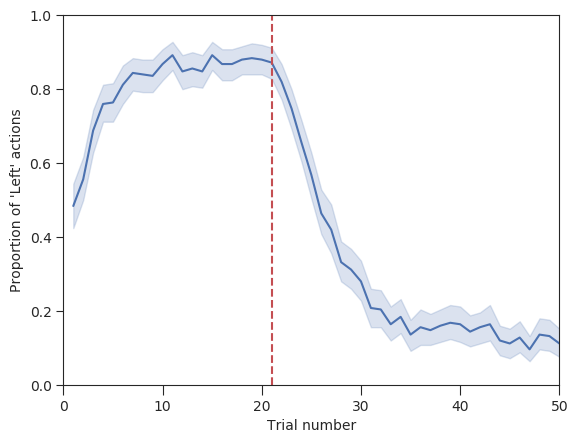

In [284]:
# switch case figure

sns.set_style("ticks")
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
ax = sns.lineplot(x="trial", y="decision", data=decisiondata, ci=95)
ax.set_facecolor('w')
ax.set_ylabel("Proportion of 'Left' actions")
ax.set_xlabel("Trial number")
ax.set_ylim(0,1)
ax.set_xlim(0,50)
ax.axvline(21, color='r', linestyle='--')
plt.savefig("fig1.svg")

In [222]:
# plot a few trials from a single sim for a detailed figure

from cycler import cycler

sns.reset_orig()
sns.set_style("ticks")

plt.rcParams['axes.prop_cycle'] = cycler(color='brmrcmykg')

confignum = 1
repnum = 0

result = resultsB[confignum][repnum]

stagecount = len(decisionsB[confignum][repnum])
reacttimes = []
reactions = []
allreactions = []
for i in range(0, stagecount):
    if decisionsB[confignum][repnum][i]['pathvals'] != None and len(decisionsB[confignum][repnum][i]['pathvals']) > 0:
        reactions.append(1-decisionsB[confignum][repnum][i]['pathvals'][0])
    else:
        reactions.append(0.5)
    reacttimes.append(decisionsB[confignum][repnum][i]['time'])

f, (ax1, ax2, ax3, ax4, ax5, ax7, ax8, ax9, ax10, ax11) = plt.subplots(10, 1, figsize=(16,24), sharex=True)

for i in range(0,result['dims']['choices']):
    result['popfreqs'].plot(x='Time (ms)', y='D1STR_'+str(i)+'_0', ax=ax1)
    result['popfreqs'].plot(x='Time (ms)', y='D2STR_'+str(i)+'_0', ax=ax2)
    result['popweights'].plot(x='Time (ms)', y='D1STR_'+str(i)+'_0', ax=ax3)
    result['popweights'].plot(x='Time (ms)', y='D2STR_'+str(i)+'_0', ax=ax4)
    result['popEs'].plot(x='Time (ms)', y='D1STR_'+str(i)+'_0', ax=ax7)
    result['popEs'].plot(x='Time (ms)', y='D2STR_'+str(i)+'_0', ax=ax8)
    result['popfreqs'].plot(x='Time (ms)', y='Th_'+str(i)+'_0', ax=ax10)


result['dopamine'].plot(x='Time (ms)', y='D1STR_0_0', ax=ax9, color='k')

result['popQ1s'].plot(x='Time (ms)', y='D1STR_0_0', ax=ax5)
result['popQ2s'].plot(x='Time (ms)', y='D1STR_0_0', ax=ax5)



ax11.plot(reacttimes,reactions, marker='o', linestyle='None')
ax11.plot(reacttimes, [1-x for x in volatile_pattern][:len(reacttimes)])
#ax11.plot([reacttimes[i] for i in [0,2,3,4]],[reactions[i] for i in [0,2,3,4]], marker='o', linestyle='None', markersize=10)
#ax11.plot([reacttimes[i] for i in [1]],[reactions[i] for i in [1]], marker='o', linestyle='None', markersize=10)

ax11.set_ylim(-0.25,1.25)
#ax11.set_xlim(0,reacttimes[4]+700)

ax1.set_ylim(.0,125)
ax2.set_ylim(.0,125)
ax3.set_ylim(.0,.35)
ax4.set_ylim(.0,.35)
ax7.set_ylim(.0,.02)
ax8.set_ylim(.0,.02)
ax9.set_ylim(-.5,1.5)
ax10.set_ylim(0,125)

labels = [item.get_text() for item in ax11.get_yticklabels()]
labels[1] = 'Right'
labels[2] = 'Left'
ax11.set_yticklabels(labels)

ax1.set_ylabel('D1 firing rate', fontsize=14)
ax2.set_ylabel('D2 firing rate', fontsize=14)
ax3.set_ylabel('D1 weight', fontsize=14)
ax4.set_ylabel('D2 weight', fontsize=14)
ax5.set_ylabel('Q value', fontsize=14)
ax7.set_ylabel('D1 eligibility', fontsize=14)
ax8.set_ylabel('D2 eligibility', fontsize=14)
ax9.set_ylabel('Dopamine', fontsize=14)
ax10.set_ylabel('Th firing rate', fontsize=14)
ax11.set_ylabel('Decision', fontsize=14)
f.align_ylabels()

ax11.set_xlabel("Time (ms)", fontsize=16)

ax1.legend(['Left','Right'],loc='upper left',fontsize=14,frameon=False)
ax2.get_legend().remove()
ax3.get_legend().remove()
ax4.get_legend().remove()
ax5.get_legend().remove()
ax7.get_legend().remove()
ax8.get_legend().remove()
ax9.get_legend().remove()
ax10.get_legend().remove()

f.set_facecolor('w')

ax1.tick_params(labelsize='large',width=1,length=8)
ax2.tick_params(labelsize='large',width=1,length=8)
ax3.tick_params(labelsize='large',width=1,length=8)
ax4.tick_params(labelsize='large',width=1,length=8)
ax5.tick_params(labelsize='large',width=1,length=8)
ax7.tick_params(labelsize='large',width=1,length=8)
ax8.tick_params(labelsize='large',width=1,length=8)
ax9.tick_params(labelsize='large',width=1,length=8)
ax10.tick_params(labelsize='large',width=1,length=8)
ax11.tick_params(labelsize='large',width=1,length=8)

ax7.locator_params(axis = 'y', nbins = 2)
ax8.locator_params(axis = 'y', nbins = 2)
ax9.locator_params(axis = 'y', nbins = 2)
ax11.locator_params(axis = 'y', nbins = 1)
#plt.savefig("fig2.svg")

IndexError: list index out of range

In [216]:
sum([int(reactions[i])^int(volatile_pattern[i]) for i in range(0,len(reactions))])/len(reactions)

0.6388888888888888

In [106]:
reacttimes

[728.026,
 1454.9388,
 2178.7622,
 2910.5835,
 3638.4058,
 4361.553,
 5081.2554,
 5800.9575,
 6531.6704,
 7254.3755,
 7974.0776,
 8690.776,
 9409.478,
 10128.179,
 10848.882,
 11563.579,
 12286.284,
 13000.981,
 13723.687,
 None]

In [112]:
[t+700 for t in [0].extend(reacttimes[:-1])]

TypeError: 'NoneType' object is not iterable

In [119]:
stimulustimes = [0]
stimulustimes.extend(reacttimes[:-3])
stimulustimes = [t+600 for t in stimulustimes]
stimulustimes

[600,
 1328.0260009765625,
 2054.9388427734375,
 2778.76220703125,
 3510.58349609375,
 4238.40576171875,
 4961.55322265625,
 5681.25537109375,
 6400.95751953125,
 7131.67041015625,
 7854.37548828125,
 8574.07763671875,
 9290.7763671875,
 10009.4775390625,
 10728.1787109375,
 11448.8818359375,
 12163.5791015625,
 12886.2841796875]

In [120]:
rewardtimes = []
rewardtimes.extend(reacttimes[:-2])
rewardtimes = [t+300 for t in rewardtimes]
rewardtimes

[1028.0260009765625,
 1754.9388427734375,
 2478.76220703125,
 3210.58349609375,
 3938.40576171875,
 4661.55322265625,
 5381.25537109375,
 6100.95751953125,
 6831.67041015625,
 7554.37548828125,
 8274.07763671875,
 8990.7763671875,
 9709.4775390625,
 10428.1787109375,
 11148.8818359375,
 11863.5791015625,
 12586.2841796875,
 13300.9814453125]

In [111]:
reacttimes[:-1]

[728.026,
 1454.9388,
 2178.7622,
 2910.5835,
 3638.4058,
 4361.553,
 5081.2554,
 5800.9575,
 6531.6704,
 7254.3755,
 7974.0776,
 8690.776,
 9409.478,
 10128.179,
 10848.882,
 11563.579,
 12286.284,
 13000.981,
 13723.687]

In [128]:
result['popfreqs'].mean()

Time (ms)    6891.266602
FSI_0          15.517794
LIPI_0          0.000000
GPi_0_0       125.779366
GPi_1_0        82.220192
STNE_0_0        8.769619
STNE_1_0        9.986689
GPeP_0_0       98.337173
GPeP_1_0       96.021217
D1STR_0_0       4.093010
D1STR_1_0      27.863724
D2STR_0_0       4.848016
D2STR_1_0      13.014070
LIP_0_0         7.461101
LIP_1_0        26.601259
Th_0_0          6.819324
Th_1_0         20.330034
dtype: float32

In [151]:
currow = result['popfreqs'][result['popfreqs']['Time (ms)'].between(99, 101)].drop(columns='Time (ms)').mean()
currow

FSI_0          6.666666
LIPI_0         0.000000
GPi_0_0      219.333267
GPi_1_0      216.666794
STNE_0_0       2.466500
STNE_1_0       2.866603
GPeP_0_0     239.399658
GPeP_1_0     247.333130
D1STR_0_0      0.000000
D1STR_1_0      0.000000
D2STR_0_0      0.666667
D2STR_1_0      0.000000
LIP_0_0        0.000000
LIP_1_0        0.000000
Th_0_0         0.000000
Th_1_0         0.000000
dtype: float32

In [136]:
t1_epochs

array([3.05360222, 2.72286828, 1.26243441, 1.94208667, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 2.80768244, 3.50404473,
       3.19565271, 3.2504249 , 2.30750885, 0.59083254, 2.50060293])

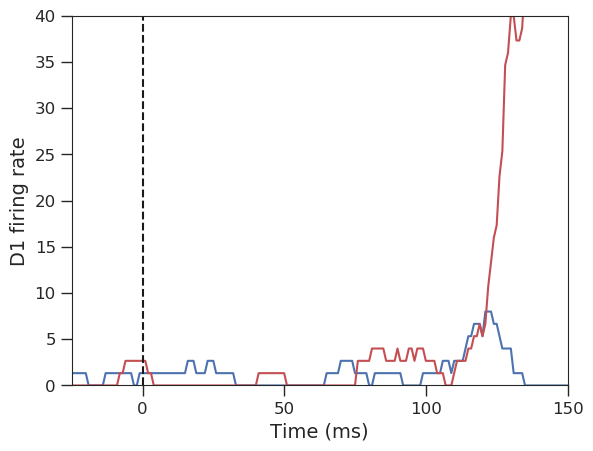

In [287]:
# striatum inset figure

shiftedtime = result['popfreqs'].copy()
shiftedtime['Time (ms)'] = shiftedtime['Time (ms)'] - (reacttimes[0]+600)
f, (ax1) = plt.subplots(1, 1)
f.set_facecolor('w')
shiftedtime.plot(x='Time (ms)', y='D1STR_0_0', ax=ax1)
shiftedtime.plot(x='Time (ms)', y='D1STR_1_0', ax=ax1)
ax1.set_xlim(-25,150)
ax1.set_ylim(0,40)
ax1.get_legend().remove()
ax1.set_ylabel('D1 firing rate', fontsize=14)
ax1.set_xlabel('Time (ms)', fontsize=14)
ax1.axvline(0, color='k', linestyle='--')
ax1.tick_params(labelsize='large',width=1,length=8)
ax1.locator_params(axis = 'x', nbins = 4)
plt.savefig("fig3.svg")

In [107]:
reactions

[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0.5]